# <center>Saving Frat Parties, One Bop at a Time</center>
<center>Aleem Virani</center>

## <center>Introduction</center>
Fraternity parties: a staple of the modern college experience. Every college student seems to have this shared experience, no matter what college they go to. On television, these parties were protrayed as an unforgettable experience with DJs playing hit after hit, students dancing on tables, and everybody similing and having a good time. However, after conducting my own research as well as talking with some of my more "outgoing" friends, this wasn't the case. Sure people do have a good time, but the good times are short lived. Columbia student, Huber Gonzalez, documented <a href = https://www.columbiaspectator.com/spectrum/2016/09/22/your-first-frat-party-play-play-timeline-if-youve-never-been-frat-party-its-time/>his experience</a> at party in Columbia. In his words, the "turn-up" started at 12:04 am and was quickly followed by the "realization" at 12:43 am where, according to Gonzalez, "...the frat's completely out of booze, the music starts to suck, and everyone's ready to bounce the f*** outta there." In 40 minutes, the "party" is seemingly over. Assuming an average song length of around 3 minutes, the party ended after 13 songs. If things don't change fast, the phrase "Party All Night" will be as revelant to the next generation as the fax machine is to this generation, and who better to lead this change than a third year Computer Science nerd with asthma. In this project, I take a look at what audio features make up party songs using the Spotify API and Spotipy, as well as create a classification model to help people pick out good songs to play at a party.

## <center>Setup</center>

For this project, we need to import and install multiple libraries: <a href = https://spotipy.readthedocs.io/en/2.21.0/>Spotipy</a>, <a href = https://pandas.pydata.org/pandas-docs/stable/>Pandas</a>, <a href = https://seaborn.pydata.org/>Seaborn</a>, 
<a href = https://docs.scipy.org/doc/numpy/user/>Numpy</a>, <a href = http://scikit-learn.org/stable/documentation.html>Scikit-learn</a>, and more.

In [45]:
%%capture
pip install spotipy --upgrade

In [46]:
%%capture
pip install lazypredict

In [47]:
#Used to interact with Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
#Used for classification
from xgboost import XGBClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC
from sklearn.metrics import precision_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


Now that we have our tools, the next thing we have to do is be able to make calls to the Spotify API through Spotipy. To do this, we need a client id and a client secret key. Both of these can be obtained by registering an app through the <a href = https://developer.spotify.com/dashboard/login>Spotify for Developers</a> portal.

In [48]:
#Create a Spotipy object to make Spotify API calls
auth_manager = SpotifyClientCredentials(client_id='3c3fbee31f304f398f75b4de0cad95f6',client_secret='b09b4ea5db8342ae87d0832a2d9eb529')
sp = spotipy.Spotify(auth_manager=auth_manager)

Great! Now we that we have a Spotipy object, we can start to collect our data.

## <center>Data Collection</center>

The first step of this process is to obtain songs that would play at a fraternity party. To get the songs, I simply searched "Fraternity Playlists" on the Spotify Web Player and stored the playlists IDs in a List. From this, I used the Spotipy object to get the name of each song and stored this, along with the song ID into a Data Frame. I also added a column "Frat" and filled it all with 1s to indicate that these are good songs to play at a party.

In [49]:
frat_playlists = ['12mcHHoTRZF6cAxfjAvMPP', '3Gd67DHBoA9QRSYk2hhHdq', '2KfDfNcRVrNVYgU46eJYcJ', '2mmdzFwPVURPPeWSG2Gadh', '08SEeX1N03RuaRAmKhin8F', '1ea6YoJmz0eaKzIxjW5PPQ', '1RQ3vAw4gEmLeJE96faCVc']

In [50]:
songs = []
#Collect the IDs of all the songs present in these playlists and store them in an array
for p in frat_playlists:
    x = sp.playlist_tracks(p)
    for i in range(0,len(x['items'])):
        songs.append(x['items'][i]['track']['id'])

In [51]:
#Got rid of all duplicate IDs by transforming the list to a set and back
songs = list(set(songs))

In [52]:
#Create empty DataFrame
df = pd.DataFrame()

In [53]:
#Add the ID the tracks to the Data Frame
df['ID'] = songs
#Mark each of these entries as 1 to indicate that these are good party songs and add to the Data Frame
df['Frat'] = [1] * len(df)

The next step of this process was to get the audio features of each of the songs present within the Data Frame and add it to said Data Frame. This is an important step as these features will end up helping when determing whether a song is good for a party or not. 

In [54]:
#Go through each of the rows in the DF and get the danceability, energy, loudness, speechiness, 
#acousticness, instrumentalness, liveness, valence, and tempo of each song
danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo = [],[],[],[],[],[],[],[],[]
for index, row in df.iterrows():
    #Make a central call to the Spotipy API to get the audio features of each track
    info = sp.audio_features(tracks = [df.loc[index, 'ID']])[0]
    danceability.append(info['danceability'])
    energy.append(info['energy'])
    loudness.append(info['loudness'])
    speechiness.append(info['speechiness'])
    acousticness.append(info['acousticness'])
    instrumentalness.append(info['instrumentalness'])
    liveness.append(info['liveness'])
    valence.append(info['valence'])
    tempo.append(info['tempo'])

#Add these metrics to the Data Frame
df['danceability'] = danceability
df['energy'] = energy
df['loudness'] = loudness
df['speechiness'] = speechiness
df['acousticness'] = acousticness
df['instrumentalness'] = instrumentalness
df['liveness'] = liveness
df['valence'] = valence
df['tempo'] = tempo

In [55]:
#Output party song Data Frame
display(df)

,ID,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4iCKHGl4ij4YMwFrUZLGEQ,1,0.65,0.88,-0.93,0.08,0.08,0.00,0.54,0.43,126.04
1,4Km5HrUvYTaSUfiSGPJeQR,1,0.93,0.67,-5.31,0.24,0.06,0.00,0.12,0.17,127.08
2,5KBARWIxeMGkvUax9VtVC9,1,0.90,0.81,-6.29,0.26,0.00,0.00,0.07,0.59,105.04
3,1000nHvUdawXuUHgBod4Wv,1,0.70,0.59,-6.15,0.08,0.34,0.00,0.12,0.47,153.85
4,1bM50INir8voAkVoKuvEUI,1,0.78,0.74,-5.81,0.03,0.20,0.00,0.36,0.33,130.00
...,...,...,...,...,...,...,...,...,...,...,...
513,3tjFYV6RSFtuktYl3ZtYcq,1,0.70,0.72,-3.56,0.04,0.22,0.00,0.27,0.76,90.99
514,3rfhI32Il2hVRKDkuGeeen,1,0.59,0.91,-3.43,0.09,0.04,0.00,0.26,0.76,128.02
515,696DnlkuDOXcMAnKlTgXXK,1,0.62,0.60,-5.62,0.15,0.05,0.00,0.46,0.46,116.73
516,56uXDJRCuoS7abX3SkzHKQ,1,0.77,0.65,-6.98,0.30,0.06,0.00,0.21,0.57,155.05


Now that we have created a Data Frame for songs that would be good to play at a frat party, it's to do the same thing for songs that would be __bad__ to play at a frat party. Besides figuring out how how Spotipy worked, this was the hardest part of the project. What would constitute as a bad song? I ended up crowdsourcing some answers found that "bad" songs include songs written by Taylor Swift, sad songs, slow songs, songs written by Olivia Rodrigo, country songs, and Kids Bop. As I did before, I created a new Data Frame that incorporates these selections and filled it with the song ID, the song name, an indicator that showed these songs were not meant for a party, and the audio features of each track. The one step in the process that differed with the previous Data Frame creation was the fact that I got rid of tracks that were considered to be "bad" if they were also in the "good" list of songs. This was to make sure that each song only belonged to the "good" section or the "bad" section and not both.

In [56]:
bad_music = ['5ksaUaYEgnywCzO6nmAIwN', '6duuzFPn741MPpmaurNbH1', '37i9dQZF1EQmPV0vrce2QZ', '37i9dQZF1DWWEJlAGA9gs0', '4kStQdar45aPq6v97qT2Dc', '3a6Rd7GxLcl6ZCSfy2B0oL', '1Tsa6hKcC2TIJ6ZcbsEhNx', '37i9dQZF1DZ06evO0WqnZe']

In [57]:
bad_songs = []
#Collect the IDs of all the songs present in these playlists and store them in an array
for p in bad_music:
    x = sp.playlist_tracks(p)
    for i in range(0,len(x['items'])):
        bad_songs.append(x['items'][i]['track']['id'])

In [58]:
#If a bad song also appears as a good song, delete it from the bad_songs array 
for i in bad_songs:
    if i in songs:
        index = bad_songs.index(i)
        bad_songs.pop(index)
#Got rid of all duplicate IDs by transforming the list to a set and back
bad_songs = list(set(bad_songs))

In [59]:
#Create a Bad Data Frame for bad songs to play at a party 
bdf = pd.DataFrame()

In [60]:
#Add the ID of the tracks to the Bad Data Frame
bdf['ID'] = bad_songs 
#Mark each of these entries as 0 to indicate that these are bad party songs and add to the Bad Data Frame
bdf['Frat'] = [0]*len(bdf)

In [61]:
#Bad Data Frame
display(bdf)

,ID,Frat
0,17Jz3qHrV3d0aDcK3HWzyp,0
1,14BH4qO7pgCmIe6mgLKOK3,0
2,7pt64sepCy5QmDrgy9wOJS,0
3,1wPiUPw9IqSchKwinw7dCf,0
4,7uf3aFC1msj0t5cYImgOWy,0
...,...,...
658,1Ac5BDsGUMQ3tsW2vnc52x,0
659,5Qnrgqy1pAm9GyNQOgyVFz,0
660,02nMYbIiYIzaFA3D3Bkn6W,0
661,0F3kMN9OPXr0b5metJq2M1,0


In [62]:
#Go through each of the rows in the Bad DF and get the danceability, energy, loudness, speechiness, 
#acousticness, instrumentalness, liveness, valence, and tempo of each song
danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo = [],[],[],[],[],[],[],[],[]
for index, row in bdf.iterrows():
    #Make a central call to the Spotipy API to get the audio features of each track
    info = sp.audio_features(tracks = [bdf.loc[index, 'ID']])[0]
    danceability.append(info['danceability'])
    energy.append(info['energy'])
    loudness.append(info['loudness'])
    speechiness.append(info['speechiness'])
    acousticness.append(info['acousticness'])
    instrumentalness.append(info['instrumentalness'])
    liveness.append(info['liveness'])
    valence.append(info['valence'])
    tempo.append(info['tempo'])
#Add these metrics to the Bad Data Frame
bdf['danceability'] = danceability
bdf['energy'] = energy
bdf['loudness'] = loudness
bdf['speechiness'] = speechiness
bdf['acousticness'] = acousticness
bdf['instrumentalness'] = instrumentalness
bdf['liveness'] = liveness
bdf['valence'] = valence
bdf['tempo'] = tempo

Now that we have our two Data Frames, it's time to combine them into one main Data Frame so we can start with our data exploration stage.

In [63]:
#Good df
display(df)

,ID,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4iCKHGl4ij4YMwFrUZLGEQ,1,0.65,0.88,-0.93,0.08,0.08,0.00,0.54,0.43,126.04
1,4Km5HrUvYTaSUfiSGPJeQR,1,0.93,0.67,-5.31,0.24,0.06,0.00,0.12,0.17,127.08
2,5KBARWIxeMGkvUax9VtVC9,1,0.90,0.81,-6.29,0.26,0.00,0.00,0.07,0.59,105.04
3,1000nHvUdawXuUHgBod4Wv,1,0.70,0.59,-6.15,0.08,0.34,0.00,0.12,0.47,153.85
4,1bM50INir8voAkVoKuvEUI,1,0.78,0.74,-5.81,0.03,0.20,0.00,0.36,0.33,130.00
...,...,...,...,...,...,...,...,...,...,...,...
513,3tjFYV6RSFtuktYl3ZtYcq,1,0.70,0.72,-3.56,0.04,0.22,0.00,0.27,0.76,90.99
514,3rfhI32Il2hVRKDkuGeeen,1,0.59,0.91,-3.43,0.09,0.04,0.00,0.26,0.76,128.02
515,696DnlkuDOXcMAnKlTgXXK,1,0.62,0.60,-5.62,0.15,0.05,0.00,0.46,0.46,116.73
516,56uXDJRCuoS7abX3SkzHKQ,1,0.77,0.65,-6.98,0.30,0.06,0.00,0.21,0.57,155.05


In [64]:
#Bad df
display(bdf)

,ID,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,17Jz3qHrV3d0aDcK3HWzyp,0,0.16,0.10,-16.33,0.04,0.98,0.89,0.09,0.06,179.45
1,14BH4qO7pgCmIe6mgLKOK3,0,0.47,0.94,-3.68,0.05,0.01,0.00,0.24,0.66,75.05
2,7pt64sepCy5QmDrgy9wOJS,0,0.72,0.26,-14.06,0.26,0.67,0.00,0.10,0.17,127.88
3,1wPiUPw9IqSchKwinw7dCf,0,0.54,0.45,-6.13,0.03,0.76,0.00,0.11,0.33,82.05
4,7uf3aFC1msj0t5cYImgOWy,0,0.24,0.12,-22.41,0.05,0.93,0.66,0.13,0.19,66.33
...,...,...,...,...,...,...,...,...,...,...,...
658,1Ac5BDsGUMQ3tsW2vnc52x,0,0.44,0.55,-8.20,0.03,0.00,0.01,0.20,0.10,99.91
659,5Qnrgqy1pAm9GyNQOgyVFz,0,0.43,0.10,-22.39,0.04,0.97,0.33,0.12,0.16,120.48
660,02nMYbIiYIzaFA3D3Bkn6W,0,0.60,0.78,-6.19,0.06,0.01,0.00,0.11,0.87,171.00
661,0F3kMN9OPXr0b5metJq2M1,0,0.41,0.25,-14.71,0.05,0.97,0.00,0.10,0.22,149.90


In [65]:
#Combine dfs
df = df.append(bdf).reset_index(drop=True)

In [66]:
#Combined df
display(df)

,ID,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4iCKHGl4ij4YMwFrUZLGEQ,1,0.65,0.88,-0.93,0.08,0.08,0.00,0.54,0.43,126.04
1,4Km5HrUvYTaSUfiSGPJeQR,1,0.93,0.67,-5.31,0.24,0.06,0.00,0.12,0.17,127.08
2,5KBARWIxeMGkvUax9VtVC9,1,0.90,0.81,-6.29,0.26,0.00,0.00,0.07,0.59,105.04
3,1000nHvUdawXuUHgBod4Wv,1,0.70,0.59,-6.15,0.08,0.34,0.00,0.12,0.47,153.85
4,1bM50INir8voAkVoKuvEUI,1,0.78,0.74,-5.81,0.03,0.20,0.00,0.36,0.33,130.00
...,...,...,...,...,...,...,...,...,...,...,...
1176,1Ac5BDsGUMQ3tsW2vnc52x,0,0.44,0.55,-8.20,0.03,0.00,0.01,0.20,0.10,99.91
1177,5Qnrgqy1pAm9GyNQOgyVFz,0,0.43,0.10,-22.39,0.04,0.97,0.33,0.12,0.16,120.48
1178,02nMYbIiYIzaFA3D3Bkn6W,0,0.60,0.78,-6.19,0.06,0.01,0.00,0.11,0.87,171.00
1179,0F3kMN9OPXr0b5metJq2M1,0,0.41,0.25,-14.71,0.05,0.97,0.00,0.10,0.22,149.90


## <center>Data Exploration</center>

For this section, I wanted to go over the audio features of the songs found within the Data Frame. The first thing I wanted to know was if certain features were more influential than others when determining if a song is good for a party. To do this, I decided to create a correlation matrix and heatmap of the correlation matrix. 

In [67]:
sns.set_theme()

<AxesSubplot:>

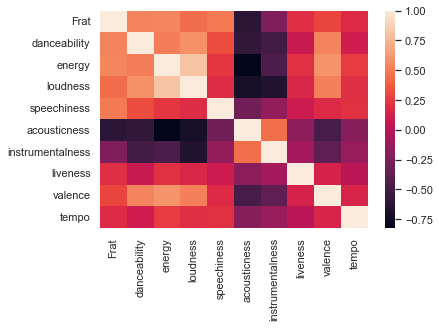

In [68]:
#Heatmap of correlation matrix
display(sns.heatmap(df.corr()))

In [69]:
#Correlation matrix of df
display(df.corr())

,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Frat,1.00,0.53,0.54,0.44,0.49,-0.62,-0.24,0.21,0.29,0.18
danceability,0.53,1.00,0.51,0.58,0.32,-0.58,-0.50,0.08,0.53,0.11
energy,0.54,0.51,1.00,0.81,0.24,-0.82,-0.46,0.21,0.60,0.26
loudness,0.44,0.58,0.81,1.00,0.19,-0.71,-0.66,0.17,0.51,0.21
speechiness,0.49,0.32,0.24,0.19,1.00,-0.30,-0.15,0.09,0.18,0.21
acousticness,-0.62,-0.58,-0.82,-0.71,-0.30,1.00,0.45,-0.18,-0.48,-0.21
instrumentalness,-0.24,-0.50,-0.46,-0.66,-0.15,0.45,1.00,-0.08,-0.38,-0.13
liveness,0.21,0.08,0.21,0.17,0.09,-0.18,-0.08,1.00,0.14,0.01
valence,0.29,0.53,0.60,0.51,0.18,-0.48,-0.38,0.14,1.00,0.16
tempo,0.18,0.11,0.26,0.21,0.21,-0.21,-0.13,0.01,0.16,1.00


To me, a strong correlation is anything above 40%. Based on this, the attributes that have the most impact on the classification of a song are __"danceability"__, __"energy"__, __"loudness"__, __"speechiness"__, and __"acousticness"__. With this in mind, lets look at the distribution of these attributes across the fraternity songs and non-fraternity songs within our Data Frame. 

[Text(0.5, 1.0, 'Histogram of Danceability of Songs')]

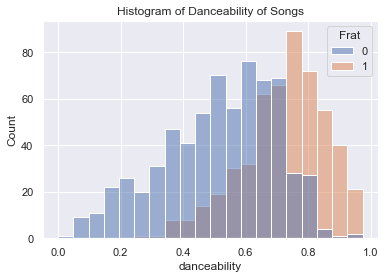

In [70]:
display(sns.histplot(data = df, x = 'danceability', hue = 'Frat').set(title = 'Histogram of Danceability of Songs'))

The main thing I saw in the histogram above was the the danceability of both frat songs and non-frat songs are left-skewed. However, it seems that, on average, danceability of frat songs are higher than that of non-frat songs. Overall it seems that while both classes of songs are danceable, you would find more poeple dancing to a frat song.  

[Text(0.5, 1.0, 'Histogram of Energy of Songs')]

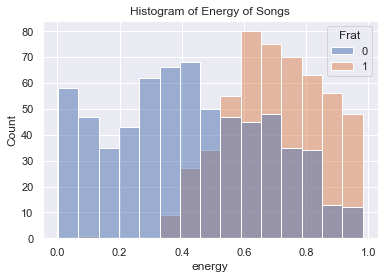

In [71]:
display(sns.histplot(data = df, x = 'energy', hue = 'Frat').set(title = 'Histogram of Energy of Songs'))

In this histogram, it seems that the energy of frat songs are left skewed, while the energy of non-frat songs are slightly right skewed. This means that the energy of non-frat songs would be on the lower end, while frat songs would have higher energy. This doesn't surprise me as the whole reason why people play frat songs in a party is to get people active and moving.

[Text(0.5, 1.0, 'Histogram of Loudness of Songs')]

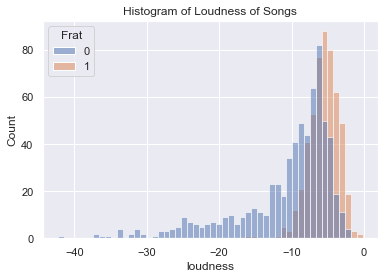

In [72]:
display(sns.histplot(data = df, x = 'loudness', hue = 'Frat').set(title = 'Histogram of Loudness of Songs'))

Here, non-frat songs are left skewed while frat songs and normally distributed. Based on this, it seems like there is high variance in the loudness of a non-frat songs as the values range from -40 to -4 while frat songs range from -12 to 0. Lastly, it seems that frat songs tend to be more loud than non-frat songs.

[Text(0.5, 1.0, 'Histogram of Speechiness of Songs')]

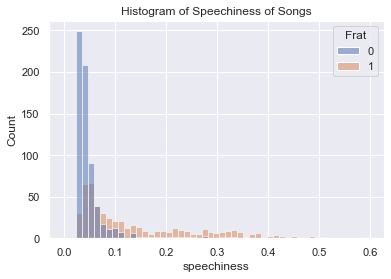

In [73]:
display(sns.histplot(data = df, x = 'speechiness', hue = 'Frat').set(title = 'Histogram of Speechiness of Songs'))

In this histogram, it's clear that non-frats songs are right skewed and not speechy at all. This is in stark contrast to frat songs which are also right skewed, but have high volatility as the speechiness varies between 0.04-0.5.

[Text(0.5, 1.0, 'Histogram of Acousticness of Songs')]

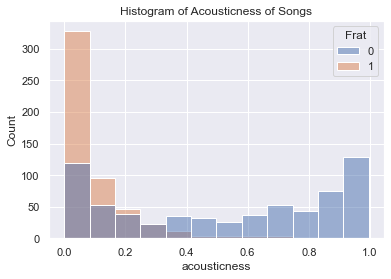

In [74]:
display(sns.histplot(data = df, x = 'acousticness', hue = 'Frat').set(title = 'Histogram of Acousticness of Songs'))

Lastly in this histogram, non-frat songs seem to be bimodal while frat songs are unimodal and skewed to the right. This tells me that the acoustics of frat songs tend to be on the lower end, while the acoustics of non-frat songs tend to either be very low or very high. From this data exploration, we now know that fraternity songs tend to be loud, high in energy, somewhat speechy, danceable, and have very little acoustic presence. I was surprised that tempo wasn't a factor in this classification, as I thought that faster songs would be more favorable at parties, but I guess that this is not the case.


## <center>Song Classification</center>

Now that we've taken a look at what factors influence the classification of a song the most, the question still begs: "Can we come up with a way to determine what songs are good to play at parties?" The answer, of course, is yes, with the help of a classification model. The first step in this process is to create a train-test split for the data. Here, I decided to not use every attribute that we collected earlier, but rather the 5 attributes that we found to be most impactful when deciding if a song is good to play at a frat party.  

In [75]:
#Target is the frat column
y = df['Frat']
#Classify on 'danceability', 'energy', 'loudness', 'speechiness', and'acousticness'
X = df[['danceability', 'energy', 'loudness', 'speechiness','acousticness']]
#Use 20% of the data to test and the rest to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

The next step in the process is to train a model with this data. However, I had no idea which model would be best in this scenario. To solve this, I decided to use LazyClassifier to run a bunch of different classificatiion models and pick the best one to use on the data.

In [76]:
#Create and deploy LazyClassifier model
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████████████████████████████████████▌ | 28/29 [00:00<00:00, 35.26it/s]

[20:22:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 30.78it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.86,0.87,0.87,0.86,0.01
CalibratedClassifierCV,0.86,0.87,0.87,0.86,0.03
LogisticRegression,0.86,0.87,0.87,0.86,0.01
Perceptron,0.84,0.86,0.86,0.84,0.01
SVC,0.85,0.86,0.86,0.85,0.03
SGDClassifier,0.84,0.86,0.86,0.84,0.01
NuSVC,0.84,0.86,0.86,0.84,0.06
NearestCentroid,0.83,0.85,0.85,0.83,0.01
RidgeClassifierCV,0.84,0.85,0.85,0.84,0.01


This is good, but I wanted to see if by using all the data to classify, I would get better accuracy results. 

In [77]:
#Target is the frat column
y = df['Frat']
#Use all the Spotify attributes to classify a song
X = df.drop(['ID', 'Frat'], axis = 1)
#Use 20% of the data to test and the rest to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [78]:
#Create and deploy LazyClassifier model
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████████████████████████████████████▌ | 28/29 [00:00<00:00, 32.88it/s]

[20:22:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 30.39it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.86,0.87,0.87,0.87,0.09
RandomForestClassifier,0.86,0.87,0.87,0.87,0.18
LogisticRegression,0.85,0.85,0.85,0.85,0.01
XGBClassifier,0.84,0.85,0.85,0.84,0.12
SGDClassifier,0.83,0.84,0.84,0.83,0.01
Perceptron,0.83,0.84,0.84,0.83,0.01
CalibratedClassifierCV,0.84,0.84,0.84,0.84,0.06
BaggingClassifier,0.84,0.84,0.84,0.84,0.04
NearestCentroid,0.81,0.84,0.84,0.81,0.01


I've run this several times and for the most part, the results slightly improve. Another way to potentially increase the results of the classification was to standardize the data. The general formula I used was to subract the mean from the column from each value in the column and divide it by the standard deviation of the column. 

In [79]:
#Create backup DF 
backup = df
#For each column, subtract the mean from each value in the column and divide it by the standard 
#deviation of the column.
df['danceability'] = (df['danceability']-df['danceability'].mean())/df['danceability'].std()
df['energy'] = (df['energy']-df['energy'].mean())/df['energy'].std()
df['loudness'] = (df['loudness']-df['loudness'].mean())/df['loudness'].std()
df['speechiness'] = (df['speechiness']-df['speechiness'].mean())/df['speechiness'].std()
df['acousticness'] = (df['acousticness']-df['acousticness'].mean())/df['acousticness'].std()
df['instrumentalness'] = (df['instrumentalness']-df['instrumentalness'].mean())/df['instrumentalness'].std()
df['liveness'] = (df['liveness']-df['liveness'].mean())/df['liveness'].std()
df['valence'] = (df['valence']-df['valence'].mean())/df['valence'].std()
df['tempo'] = (df['tempo']-df['tempo'].mean())/df['tempo'].std()

In [80]:
#Standardized DF
df

,ID,Frat,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4iCKHGl4ij4YMwFrUZLGEQ,1,0.21,1.33,1.29,-0.09,-0.72,-0.35,2.66,-0.05,0.22
1,4Km5HrUvYTaSUfiSGPJeQR,1,1.65,0.48,0.55,1.55,-0.79,-0.35,-0.38,-1.12,0.26
2,5KBARWIxeMGkvUax9VtVC9,1,1.51,1.06,0.38,1.70,-0.96,-0.35,-0.78,0.61,-0.50
3,1000nHvUdawXuUHgBod4Wv,1,0.50,0.19,0.40,-0.17,0.02,-0.35,-0.38,0.15,1.17
4,1bM50INir8voAkVoKuvEUI,1,0.90,0.79,0.46,-0.60,-0.40,-0.35,1.36,-0.47,0.36
...,...,...,...,...,...,...,...,...,...,...,...
1176,1Ac5BDsGUMQ3tsW2vnc52x,0,-0.85,-0.01,0.05,-0.66,-0.96,-0.30,0.20,-1.39,-0.67
1177,5Qnrgqy1pAm9GyNQOgyVFz,0,-0.89,-1.77,-2.37,-0.49,1.82,0.99,-0.40,-1.15,0.03
1178,02nMYbIiYIzaFA3D3Bkn6W,0,-0.01,0.95,0.40,-0.34,-0.94,-0.35,-0.44,1.79,1.76
1179,0F3kMN9OPXr0b5metJq2M1,0,-1.01,-1.17,-1.06,-0.45,1.80,-0.34,-0.51,-0.92,1.04


Now that we have standardized the data, let's repeat the steps above see whether or not the models have improved.

In [81]:
#Target is the frat column
y = df['Frat']
#Classify on 'danceability', 'energy', 'loudness', 'speechiness', and'acousticness'
X = df[['danceability', 'energy', 'loudness', 'speechiness','acousticness']]
#Use 20% of the data to test and the rest to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [82]:
#Create and deploy LazyClassifier model
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 36.25it/s]

[20:22:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.86,0.87,0.87,0.86,0.01
CalibratedClassifierCV,0.86,0.87,0.87,0.86,0.03
LogisticRegression,0.86,0.87,0.87,0.86,0.01
Perceptron,0.84,0.86,0.86,0.84,0.01
SVC,0.85,0.86,0.86,0.85,0.03
SGDClassifier,0.84,0.86,0.86,0.84,0.01
NuSVC,0.84,0.86,0.86,0.84,0.05
NearestCentroid,0.83,0.85,0.85,0.83,0.01
RidgeClassifierCV,0.84,0.85,0.85,0.84,0.01


In [83]:
#Target is the frat column
y = df['Frat']
#Use all the Spotify attributes to classify a song
X = df.drop(['ID', 'Frat'], axis = 1)
#Use 20% of the data to test and the rest to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [84]:
#Create and deploy LazyClassifier model
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████████████████████████████████████▌ | 28/29 [00:00<00:00, 34.44it/s]

[20:22:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 31.58it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.86,0.87,0.87,0.87,0.09
RandomForestClassifier,0.86,0.87,0.87,0.87,0.17
LogisticRegression,0.85,0.85,0.85,0.85,0.01
XGBClassifier,0.84,0.85,0.85,0.84,0.11
SGDClassifier,0.83,0.84,0.84,0.83,0.01
Perceptron,0.83,0.84,0.84,0.83,0.01
CalibratedClassifierCV,0.84,0.84,0.84,0.84,0.06
BaggingClassifier,0.84,0.84,0.84,0.84,0.04
NearestCentroid,0.81,0.84,0.84,0.81,0.01


Overall, while the models used may have changed, the overall accuracy hasn't changed enough to justify using standardized over non-standardized data. Based on this, I decided to just use the non-standardized data for the rest of my calculations.

Although these models yielded great results, the key metric that I really care about here is precision, as I want to find what proportion of predicted frat songs was actually correct. After running LazyClassifier several times, I decided to take the top 4 models that kept reappearing during my multiple trials and measure the precision of each of them. 

The first model I tested was Logistic Regression:

In [85]:
#switch DF to earlier df
df = backup
#Create and test LR model
clf = LogisticRegression().fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Score: ' + str(precision_score(y_test, y_predict, average='micro')))

Score: 0.8481012658227848


The next model I tested was ExtraTreesClassifier:

In [86]:
#Create and test ExtraTreesClassifier model
clf = ExtraTreesClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Score: ' + str(precision_score(y_test, y_predict, average='micro')))

Score: 0.869198312236287


The next model I tested was SGDClassifier:

In [87]:
#Create and test SGDClassifier model
clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Score: ' + str(precision_score(y_test, y_predict, average='micro')))

Score: 0.8185654008438819


The last model I checked was LinearSVC:

In [88]:
#Create and test LinearSVC model
clf = make_pipeline(StandardScaler(),LinearSVC())
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Score: ' + str(precision_score(y_test, y_predict, average='micro')))

Score: 0.8312236286919831


Overall, it seems that the best model to use here is <a href = https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html>ExtraTreesClassifier</a>, as it has the highest percision out of all the models tested.

## <center>Conclusion</center>
It turns out that making, let alone making a hit song, is a lot deeper than people expect it to be. Before this project, I had no idea about the metrics that Spotify stores for each song. However, with the use of these metrics, we were able to not only identify defining characteristics of popular party songs, but we were able to use this information and more to create a model that can help DJs and hosts everywhere curate playlists to ensure the satisfaction of partygoers all over the world. Although the approach of this project was to determine good songs to play at a party, the project is robust enough for you to curate it to your personal needs such as trying to make a playlist for a friend or finding songs that match your current mood. The next step, if any for this project, is to find ways to increase the precision and accuracy of these models and eventually refine it enough so that they can replace a human altogether. I would also love to test the validity of my model by curating a playlist for a party and playing it for an actual crowd. Overall, I hope that this was worth the read and you were able to learn something that you didn't know earlier.